<a href="https://colab.research.google.com/github/nishanthsankar7/Wine-Review-Classification/blob/master/Wine_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset=["description", "points"])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


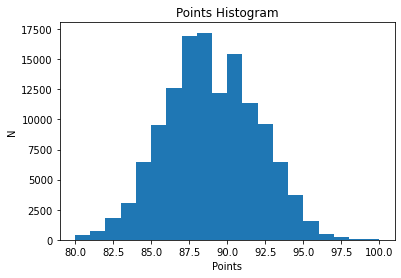

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

Embedding and Model


In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.44591174, -0.0563061 , -0.00536885, ..., -0.14906885,
        -0.03328603,  0.13012685],
       [ 0.22393693, -0.16764374, -0.03310859, ..., -0.02931332,
         0.05137185, -0.07310005],
       [ 0.634608  , -0.25384414,  0.07821072, ..., -0.2359469 ,
        -0.1339173 ,  0.32422474],
       ...,
       [ 0.30468452, -0.15697439, -0.09646668, ..., -0.10558444,
        -0.05342095, -0.10451662],
       [ 0.35104316, -0.13951126, -0.08855926, ..., -0.15489355,
        -0.16179506, -0.0357601 ],
       [ 0.2931998 , -0.37450388, -0.01148788, ..., -0.06351854,
         0.08618415,  0.05930612]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 3s 16ms/step - loss: 0.8664 - accuracy: 0.3789


[0.8664447069168091, 0.3788662850856781]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 16ms/step - loss: 0.8684 - accuracy: 0.3746


[0.8684247136116028, 0.37462490797042847]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 64s 605ms/step - loss: 0.7017 - accuracy: 0.5566 - val_loss: 0.6709 - val_accuracy: 0.6280
Epoch 2/5
102/102 [==============================] - 55s 543ms/step - loss: 0.6145 - accuracy: 0.7023 - val_loss: 0.4850 - val_accuracy: 0.8073
Epoch 3/5
102/102 [==============================] - 55s 541ms/step - loss: 0.4711 - accuracy: 0.7960 - val_loss: 0.3876 - val_accuracy: 0.8260
Epoch 4/5
102/102 [==============================] - 55s 538ms/step - loss: 0.4001 - accuracy: 0.8295 - val_loss: 0.3712 - val_accuracy: 0.8301
Epoch 5/5
102/102 [==============================] - 55s 542ms/step - loss: 0.3677 - accuracy: 0.8471 - val_loss: 0.3656 - val_accuracy: 0.8305


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 1s 74ms/step - loss: 0.3803 - accuracy: 0.8261


[0.3803127408027649, 0.8260501623153687]

Long short-term memory

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 155ms/step - loss: 0.6928 - accuracy: 0.5584


[0.692844033241272, 0.5583596229553223]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 55s 478ms/step - loss: 0.5465 - accuracy: 0.7136 - val_loss: 0.3772 - val_accuracy: 0.8257
Epoch 2/5
102/102 [==============================] - 50s 487ms/step - loss: 0.3687 - accuracy: 0.8352 - val_loss: 0.3604 - val_accuracy: 0.8397
Epoch 3/5
102/102 [==============================] - 51s 490ms/step - loss: 0.3505 - accuracy: 0.8439 - val_loss: 0.3516 - val_accuracy: 0.8391
Epoch 4/5
102/102 [==============================] - 48s 470ms/step - loss: 0.3425 - accuracy: 0.8473 - val_loss: 0.3504 - val_accuracy: 0.8419
Epoch 5/5
102/102 [==============================] - 48s 470ms/step - loss: 0.3379 - accuracy: 0.8504 - val_loss: 0.3516 - val_accuracy: 0.8411


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 2s 179ms/step - loss: 0.3561 - accuracy: 0.8379


[0.3560735583305359, 0.8378981351852417]